<a href="https://colab.research.google.com/github/mingyucai/ML/blob/main/Pytorch_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import math
x = torch.linspace(-math.pi, math.pi, 2000)
y = torch.sin(x)

p = torch.tensor([1, 2, 3])
xx = x.unsqueeze(-1).pow(p)

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(3, 1),
    torch.nn.Flatten(0, 1)
)
loss_fn = torch.nn.MSELoss(reduction='sum')

In [ ]:
learning_rate = 1e-6
for t in range(2000):

    y_pred = model(xx)

    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print('iteration steps {} with loss {}'.format(t, loss.item()))

    model.zero_grad()

    loss.backward()
    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

# You can access the first layer of `model` like accessing the first item of a list
linear_layer = model[0]

# For linear layer, its parameters are stored as `weight` and `bias`.
print(f'Result: y = {linear_layer.bias.item()} + {linear_layer.weight[:, 0].item()} x + {linear_layer.weight[:, 1].item()} x^2 + {linear_layer.weight[:, 2].item()} x^3')

iteration steps 99 with loss 268.1311950683594
iteration steps 199 with loss 184.98068237304688
iteration steps 299 with loss 128.6259307861328
iteration steps 399 with loss 90.390625
iteration steps 499 with loss 64.42042541503906
iteration steps 599 with loss 46.76155471801758
iteration steps 699 with loss 34.74059295654297
iteration steps 799 with loss 26.548330307006836
iteration steps 899 with loss 20.958911895751953
iteration steps 999 with loss 17.141008377075195
iteration steps 1099 with loss 14.530141830444336
iteration steps 1199 with loss 12.742647171020508
iteration steps 1299 with loss 11.517468452453613
iteration steps 1399 with loss 10.676753997802734
iteration steps 1499 with loss 10.099177360534668
iteration steps 1599 with loss 9.701956748962402
iteration steps 1699 with loss 9.428462028503418
iteration steps 1799 with loss 9.239944458007812
iteration steps 1899 with loss 9.109861373901367
iteration steps 1999 with loss 9.020003318786621
Result: y = 0.0126009965315461

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

N = 100
L = 1000
T = 20

x = np.empty((N, L), np.float32)
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
y = np.sin(x/1.0/T).astype(np.float32)

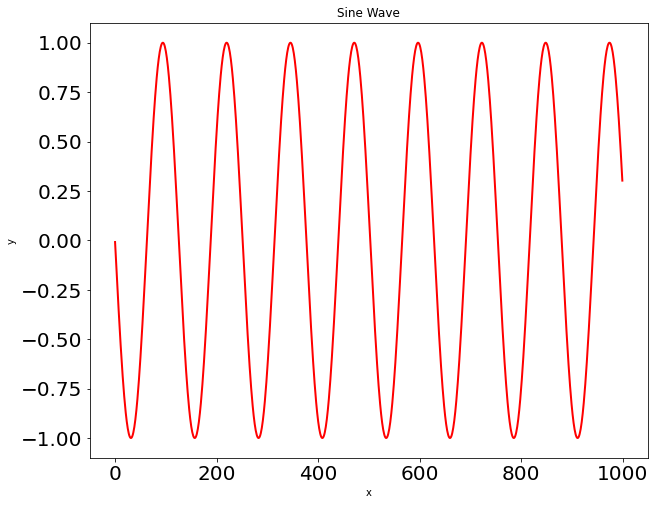

In [ ]:
plt.figure(figsize=(10, 8))
plt.title("Sine Wave")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.plot(np.arange(x.shape[1]), y[0,:], 'r', linewidth=2)
plt.show()

In [ ]:
class LSTM_predictor(nn.Module):
  def __init__(self, n_hidden = 51):
    super(LSTM_predictor, self).__init__()
    self.n_hidden = n_hidden
    # lstm1, lstm2, linear
    self.lstm1 = nn.LSTMCell(1, self.n_hidden)
    self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
    self.linear = nn.Linear(self.n_hidden, 1)

  def forward(self, x, future=0):
    # N, 100
    outputs = []
    n_samples = x.size(0)
    
    h_t1 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
    c_t1 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
    h_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
    c_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)

    for input_t in x.split(1, dim=1):
      # N, 1
      h_t1, c_t1 = self.lstm1(input_t, (h_t1, c_t1))
      h_t2, c_t2 = self.lstm2(h_t1, (h_t2, c_t2))
      output = self.linear(h_t2)
      outputs.append(output)
    
    for i in range(future):
      h_t1, c_t1 = self.lstm1(output, (h_t1, c_t1))
      h_t2, c_t2 = self.lstm2(h_t1, (h_t2, c_t2))
      output = self.linear(h_t2)
      outputs.append(output)
    
    outputs = torch.cat(outputs, dim=1)
    return outputs

In [ ]:
if __name__=="__main__":
  # y = 100 * 1000
  train_input = torch.from_numpy(y[3:, :-1]) # 97 * 9999
  train_target = torch.from_numpy(y[3:, 1:]) # 97 * 999
  print(train_input.shape, train_target.shape)
  test_input = torch.from_numpy(y[:3, :-1]) # 3 * 999
  test_target = torch.from_numpy(y[:3, 1:]) # 3*999
  print(test_input.shape, test_target.shape)

  model = LSTM_predictor()
  criterion = nn.MSELoss()
  optimizer = optim.LBFGS(model.parameters(), lr = 0.8)

torch.Size([97, 999]) torch.Size([97, 999])
torch.Size([3, 999]) torch.Size([3, 999])


In [ ]:
n_steps = 10
for i in range(n_steps):
  print("step", i)

  def closure():
    optimizer.zero_grad()
    out = model(train_input)
    loss = criterion(out, train_target)
    print(' training loss', loss.item())
    loss.backward()
    return loss
  optimizer.step(closure)

  with torch.no_grad():
    future = 1000
    pred = model(test_input, future = future)
    loss = criterion(pred[:, :-future], test_target)
    print('test loss', loss.item())
    y = pred.detach().numpy()

    plt.figure(figsize=(12, 6))
    plt.title(f"Step {i+1}")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    n = train_input.shape[1] #999
    def draw(yi, color):
      plt.plot(np.arange(n), yi[:n], color, linewidth=2)
      plt.plot(np.arange(n, n + future), yi[n:], color + ":", linewidth=2) # dashed styple

    draw(y[0], 'r')
    draw(y[1], 'b')
    draw(y[2], 'g')
    plt.savefig("predicted%d.pdf"%i)
    plt.close()

step 0
 training loss 0.491877943277359
 training loss 0.488749623298645
 training loss 0.44933822751045227
 training loss 0.3768869638442993
 training loss 0.33350321650505066
 training loss 0.16239655017852783
 training loss 0.1467762291431427
 training loss 0.02857307530939579
 training loss 0.027809416875243187
 training loss 0.027318058535456657
 training loss 0.02556031569838524
 training loss 0.02267788164317608
 training loss 0.018005525693297386
 training loss 0.009860235266387463
 training loss 0.0064741261303424835
 training loss 0.005597986280918121
 training loss 0.00503012677654624
 training loss 0.0038990916218608618
 training loss 0.0030604039784520864
 training loss 0.00320785422809422
test loss 0.0013398698065429926
step 1
 training loss 0.001505622174590826
 training loss 0.0012267527636140585
 training loss 0.0009235374163836241
 training loss 0.0008405465050600469
 training loss 0.0008163268794305623
 training loss 0.0007641052943654358
 training loss 0.00065872108